### Abstract
In this project we go through the process of collecting, storing and Analysing youtube
trending videos from 12th August 2020 till date. We demonstrate the construction of data
ingestion pipeline to regularly call the youtube API for trending videos and storing the in-
formation on a managed Microsoft Azure instance in a docker container. We further analyze
the data to extract insights about the general viewing practice of people furing the COVID-19
Pandemic period. We draw insights about which category of youtube videos are generally
seen on the youtube trending tab, we also analyze which channels are regularly seen on the
trending tab. Finally, We also train a BERT( Bidirectional Encoder Representations from
Transformers) powered model from title of collected youtube videos to estimate the category
to which a video belongs to.

In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
import matplotlib.dates as mdates

from scipy.signal import find_peaks

import torch
from torch import nn
from torch.optim import Adam

from transformers import BertTokenizer, BertModel

from tqdm import tqdm

In [2]:
username = 'root'
password = 'root'
host = '4.240.82.255'
db_name = 'youtube_db'

postgres_url = f'postgresql://{username}:{password}@{host}:5432/{db_name}'

engine = create_engine(postgres_url)

In [7]:
query = '''
SELECT *
FROM "trendingVideos"
LIMIT 20;
'''

df = pd.read_sql_query(query, con=engine)
df.columns

Index(['id', 'rank', 'title', 'channel', 'channel_id', 'description',
       'thumbnail', 'category', 'view_count', 'like_count', 'comment_count',
       'publish_date', 'trending_date', 'country'],
      dtype='object')

In [8]:
categories = pd.read_sql("""SELECT * FROM "videoCategories";""", con = engine)

categories.head()

,id,title
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports


In [9]:
query = '''
SELECT AVG("view_count"), "trending_date", "country"
FROM "trendingVideos"
GROUP BY "trending_date", "country"
ORDER BY "trending_date";
'''

df = pd.read_sql_query(query, con=engine)
df.head()

,avg,trending_date,country
0,2.105358e+06,2020-08-12,CA
1,1.297415e+06,2020-08-12,DE
2,1.280138e+06,2020-08-12,FR
3,1.836706e+06,2020-08-12,GB
4,2.621453e+06,2020-08-12,IN


In [10]:
df.country.unique()

array(['CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU', 'US'],
      dtype=object)

C:\Users\13mud\AppData\Local\Temp\ipykernel_28092\417348100.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x/1000000:.1f}M' for x in current_values])


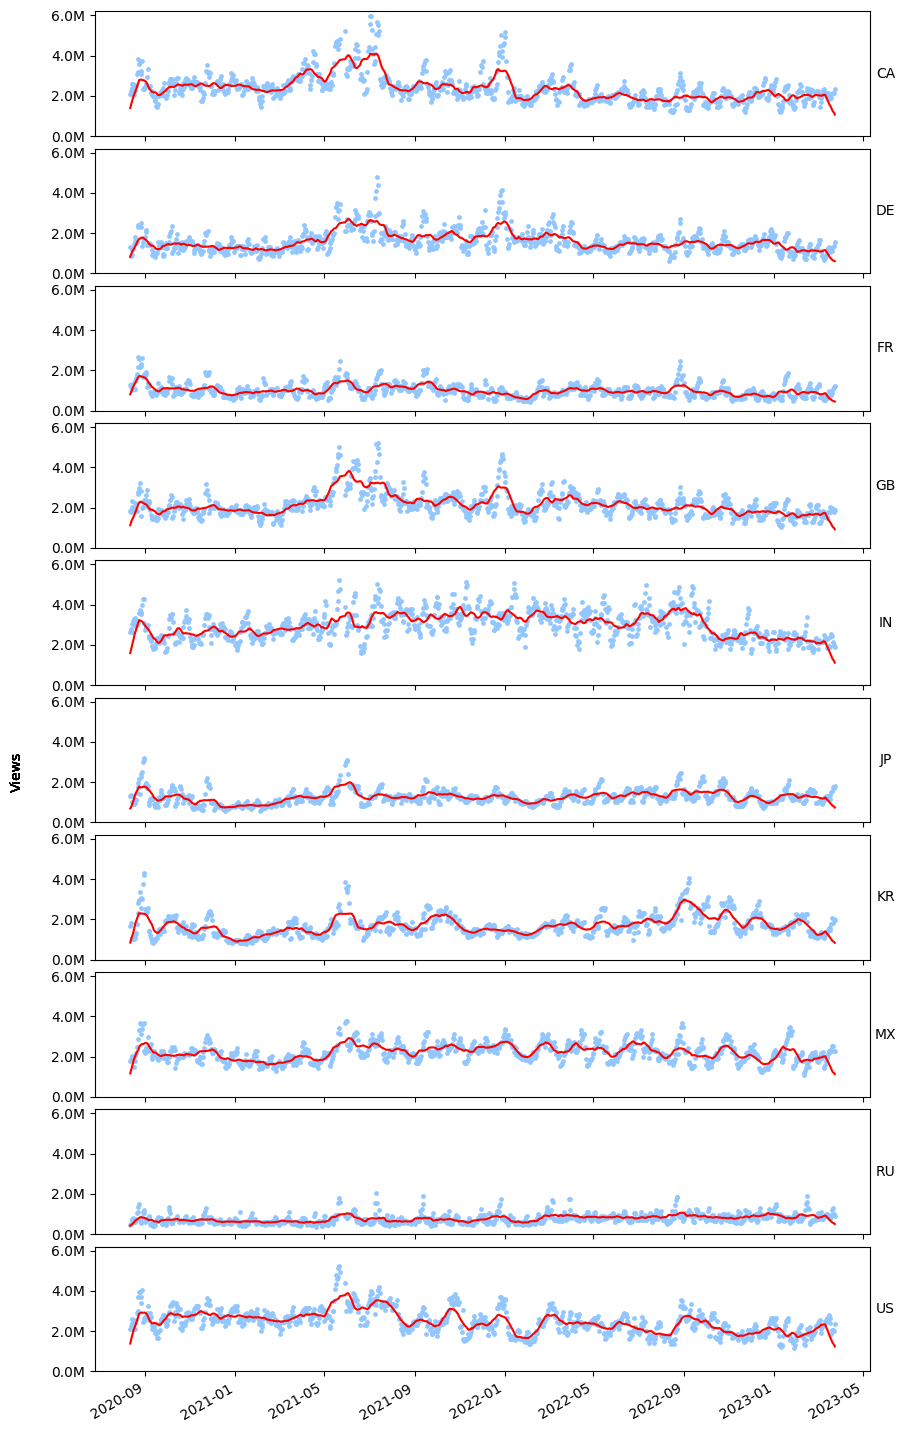

In [13]:

def plot_country(df, ax):
    x = df['trending_date']
    y = df['avg']
    
    window_size = 25
    
    window = np.ones(int(window_size))/float(window_size)
    z = np.convolve(y, window, 'same')
    
    ax.scatter(x=x, y=y, s=6)
    ax.plot(x, z, 'r')


N = len(df.country.unique())

fig, axs = plt.subplots(N, 1, sharex=True, figsize=(10, 20))

fig.subplots_adjust(hspace=0.1)

for i, country in enumerate(df.country.unique()):
    ax = axs[i]
    plot_country(df.loc[df['country'] == country], ax)
    plt.gcf().autofmt_xdate()
    
    ax.text(1.02, 0.5, country,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)
    
    ax.set_ylim(0, 6200000)
    current_values = ax.get_yticks()

    ax.set_yticklabels([f'{x/1000000:.1f}M' for x in current_values])

    fig.text(0.04, 0.5, 'Views', va='center', rotation='vertical')

plt.show()

In [13]:
query = """
SELECT "channel", COUNT("trending_date") as "trending_count", COUNT(DISTINCT "country") as "countries",
        AVG("view_count") as "avg_views", AVG("rank") as "avg_rank"
FROM "trendingVideos"
GROUP BY "channel"
ORDER BY COUNT("trending_date") DESC
LIMIT 50;
"""

df_popular_channels = pd.read_sql_query(query, con=engine)
df_popular_channels.head(10)

,channel,trending_count,countries,avg_views,avg_rank
0,BANGTANTV,4312,10,1.096245e+07,106.921614
1,JYP Entertainment,3919,10,1.777034e+07,104.735647
2,SMTOWN,3868,10,1.800122e+07,101.823164
3,HYBE LABELS,3662,10,2.190246e+07,96.327417
4,FORMULA 1,3153,9,4.363194e+06,105.787187
5,NFL,2924,10,6.492250e+06,95.740766
6,東海オンエア,2717,1,1.836095e+06,75.396393
7,BLACKPINK,2701,10,3.475369e+07,94.876342
8,NBA,2578,9,2.223982e+06,101.742048
9,The United Stand,2437,4,3.471158e+05,96.193681


In [12]:
query = """
SELECT "videoCategories"."title", (CASE WHEN "a"."count" IS NULL THEN 0 ELSE "a"."count" END) as "count"
FROM "videoCategories"
LEFT JOIN (SELECT "category", COUNT("trending_date") as "count" FROM "trendingVideos" GROUP BY "category") as "a" 
ON "a"."category" = "videoCategories"."id"
ORDER BY "count" DESC
"""

df_categories = pd.read_sql_query(query, con=engine)
df_categories.head()

,title,count
0,Entertainment,488784
1,Music,274675
2,Gaming,250904
3,People & Blogs,223141
4,Sports,187759


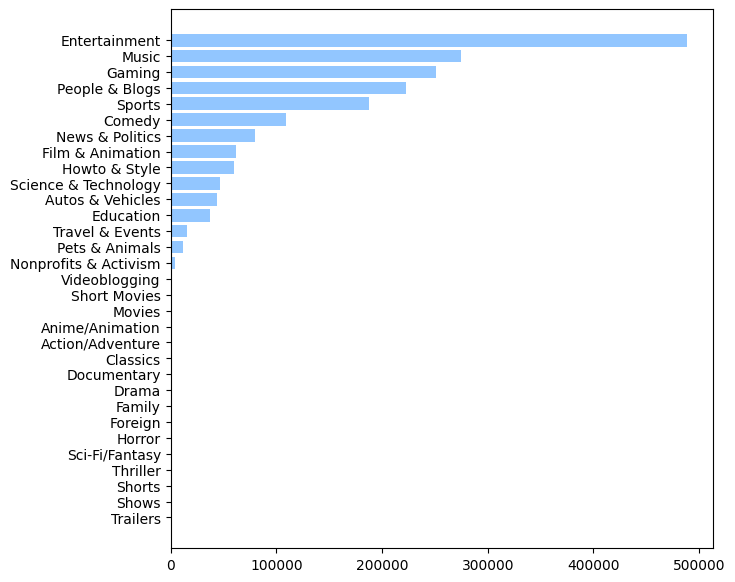

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.barh(df_categories['title'], df_categories['count'], align="center")
ax.invert_yaxis()
plt.show()

In [16]:
query = '''
SELECT "id", "title", "channel", "description", "category", MIN("country") as "country", count(*)
FROM "trendingVideos" 
WHERE "country" = 'US' OR "country" = 'IN' OR "country" = 'GB' OR "country" = 'CA'
GROUP BY "id", "title", "channel", "description", "category"
ORDER BY count(*) DESC;
'''

df = pd.read_sql_query(query, con=engine)
df

,id,title,channel,description,category,country,count
0,aONT7atzqfw,Floyd Mayweather vs Logan Paul: Fight goes the...,CBS Sports HQ,Watch the highlight from the Mayweather-Paul b...,17,CA,62
1,E6E22XQPhhg,Anything You Can Fit In The Triangle I’ll Pay For,MrBeast,Sorry for the long time no uploads! I had 4 di...,24,CA,58
2,wY6UyatwVTA,"India claim stunning series win, end Australia...",cricket.com.au,Rishabh Pant was the hero as an injury-ravaged...,17,CA,57
3,myjEoDypUD8,Watch the uncensored moment Will Smith smacks ...,Guardian News,Best actor nominee Will Smith appeared to slap...,25,CA,56
4,Df_hrHHcQ_g,Fastest Soapbox Car Wins,Dude Perfect,Build a car and race down the track! Who will ...,17,CA,55
...,...,...,...,...,...,...,...
125855,Z7XiKx_rj2I,Wafa Na Raas Aayee Song Jubin Nautiyal Ft.Hima...,T-Series,Gulshan Kumar & T-Series presents Bhushan Kuma...,10,IN,1
125856,YVJZQHNzhsM,"Virender Sehwag: Five matches, five first-ball...",ICC,Virender Sehwag announces the Indian innings o...,17,IN,1
125857,ystQh9VH4Po,Barrister Babu | बैरिस्टर बाबू | Episode 204 &...,Colors TV,Bondita is shocked when she overhears Anirudh ...,24,IN,1
125858,zbyjx-0U5nE,Paul Heyman never doubts Roman Reigns: WWE Net...,WWE,After the Universal Champion blows past the in...,17,IN,1


In [14]:

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def is_none(text):
    return text or ''

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [categories.loc[categories['id'] == category].index[0] for category in df['category']]
        self.texts = [tokenizer(title, 
                               padding='max_length', max_length = 256, truncation=True,
                                return_tensors="pt") for title in df['title']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [18]:
np.random.seed(112)
temp_df = df.sample(frac = 1, random_state=42)
df_train, df_val, df_test = np.split(temp_df, 
                                     [int(.8*len(temp_df)), int(.9*len(temp_df))])

print(len(df_train),len(df_val), len(df_test))

100688 12586 12586


In [19]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 32)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [20]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

loading model
model loaded 0.5506540507185614
Creating dataset
Dataset created
Using GPU

100%|██████████| 50344/50344 [1:57:35<00:00,  7.14it/s]

Epochs: 2 | Train Loss:  0.457                 | Train Accuracy:  0.724                 | Val Loss:  0.466                 | Val Accuracy:  0.717

100%|██████████| 50344/50344 [1:57:35<00:00,  7.14it/s]

Epochs: 3 | Train Loss:  0.343                 | Train Accuracy:  0.797                 | Val Loss:  0.430                 | Val Accuracy:  0.744

 51%|█████     | 25632/50344 [59:56<58:20,  7.06it/s]

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy: 0.754